In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, widgets
import matplotlib.dates as dates
from scipy.integrate import solve_ivp, solve_bvp
from IPython.display import Image
plt.style.use('seaborn-poster')
matplotlib.rcParams['figure.figsize'] = (10., 6.)
from scipy.special import lambertw

$x_1$: high-risk population  
$x_2$: low-risk population

In [2]:
def x_inf_u(u,sigma):
    return x_inf(u[0]+u[1],u[2]+u[3],sigma)

def x_inf(x,y,sigma):
    return -1./sigma * np.real(lambertw(-x*sigma*np.exp(-sigma*(x+y))))

def mu(x,y,sigma):
    return x*np.exp(-sigma*(x+y))

def dxinf_dy(x,y,sigma):
    xinf = x_inf(x,y,sigma)
    return -sigma*xinf/(1-sigma*xinf)

def dxinf_dx(x,y,sigma):
    xinf = x_inf(x,y,sigma)
    return (xinf/x)*(1-sigma*x)/(1-sigma*xinf)

def dJ_dx1(x1,x2,y1,y2,sigma,c1,c2):
    x = x1+x2; y = y1+y2
    xinf = x_inf(x,y,sigma)
    return -dxinf_dx(x,y,sigma)*(c1*x1+c2*x2)/x - xinf*(c1-c2)*x2/x**2

def dJ_dx2(x1,x2,y1,y2,sigma,c1,c2):
    x = x1+x2; y = y1+y2
    xinf = x_inf(x,y,sigma)
    return -dxinf_dx(x,y,sigma)*(c1*x1+c2*x2)/x - xinf*(c2-c1)*x1/x**2

def dJ_dy1(x1,x2,y1,y2,sigma,c1,c2):
    x = x1+x2; y = y1+y2
    return -dxinf_dy(x,y,sigma)*(c1*x1+c2*x2)/x

def dJ_dy2(x1,x2,y1,y2,sigma,c1,c2):  # Same as dJ_dy1
    x = x1+x2; y = y1+y2
    return -dxinf_dy(x,y,sigma)*(c1*x1+c2*x2)/x

In [18]:
def solve(beta=0.3, gamma=0.1,
          x10=0.48, x20=0.48, y10=0.01, y20=0.01,
          c1=0.5,c2=1.0,c3=10, T=100., qmax=1.,
          guess=None, loadsol=False, usejac=False):

    sigma0 = beta/gamma

    def rhs(t, u):
        # Variables: x1, x2, y1, y2, lambda_1, lambda_2, lambda_3, lambda_4
        du = np.zeros((8,len(t)))
        x1 = u[0,:]; x2 = u[1,:]; x=x1+x2
        y1 = u[2,:]; y2 = u[3,:]; y=y1+y2
        lam1 = u[4,:]; lam2 = u[5,:]; lam3 = u[6,:]; lam4 = u[7,:]

        q1star = (lam3-lam1)*beta*x1*y/(2*c3)
        q1star = np.maximum(0,np.minimum(1,q1star))

        q2star = (lam4-lam2)*beta*x2*y/(2*c3)
        q2star = np.maximum(0,np.minimum(1,q2star))

        du[0,:] = -(1-q1star)*beta*y*x1
        du[1,:] = -(1-q2star)*beta*y*x2
        du[2,:] = (1-q1star)*beta*y*x1 - gamma*y1
        du[3,:] = (1-q2star)*beta*y*x2 - gamma*y2

        du[4,:] = (lam1-lam3)*(1-q1star)*beta*y # - dL/dx1
        du[5,:] = (lam2-lam4)*(1-q2star)*beta*y # - dL/dx2
        du[6,:] = (lam1-lam3)*(1-q1star)*beta*x1 + (lam2-lam4)*(1-q2star)*beta*x2 + lam3*gamma # - dL/dy1
        du[7,:] = (lam1-lam3)*(1-q1star)*beta*x1 + (lam2-lam4)*(1-q2star)*beta*x2 + lam4*gamma # - dL/dy2

        return du

    def jac(t, u):
        m = u.shape[1]
        M = np.zeros((8,8,m))

        x1 = u[0,:]; x2 = u[1,:]; x=x1+x2
        y1 = u[2,:]; y2 = u[3,:]; y=y1+y2
        lam1 = u[4,:]; lam2 = u[5,:]; lam3 = u[6,:]; lam4 = u[7,:]

        q1 = (lam3-lam1)*beta*x1*y/(2*c3)
        q1 = np.maximum(0,np.minimum(1,q1))

        q2 = (lam4-lam2)*beta*x2*y/(2*c3)
        q2 = np.maximum(0,np.minimum(1,q2))

        M[0,0,:] = -(1-q1)*y*beta
        M[0,1,:] = 0.
        M[0,2,:] = -(1-q1)*beta*x1
        M[0,3,:] = -(1-q1)*beta*x1

        M[1,0,:] = 0.
        M[1,1,:] = -(1-q2)*y*beta
        M[1,2,:] = -(1-q2)*beta*x2
        M[1,3,:] = -(1-q2)*beta*x2

        M[2,0,:] = (1-q1)*y*beta
        M[2,1,:] = 0.
        M[2,2,:] = (1-q1)*beta*x1 - gamma
        M[2,3,:] = (1-q1)*beta*x1

        M[3,0,:] = 0.
        M[3,1,:] = (1-q2)*y*beta
        M[3,2,:] = (1-q2)*beta*x2
        M[3,3,:] = (1-q2)*beta*x2 - gamma

        M[4,2,:] = (lam1-lam3)*(1-q1)*beta
        M[4,3,:] = (lam1-lam3)*(1-q1)*beta
        M[4,4,:] = (1-q1)*beta*y
        M[4,6,:] = -(1-q1)*beta*y

        M[5,2,:] = (lam2-lam4)*(1-q2)*beta
        M[5,3,:] = (lam2-lam4)*(1-q2)*beta
        M[5,5,:] = (1-q2)*beta*y
        M[5,7,:] = -(1-q2)*beta*y

        M[6,0,:] = (lam1-lam3)*(1-q1)*beta
        M[6,1,:] = (lam2-lam4)*(1-q2)*beta
        M[6,4,:] = (1-q1)*beta*x1
        M[6,5,:] = (1-q2)*beta*x2
        M[6,6,:] = -(1-q1)*beta*x1 + gamma
        M[6,7,:] = -(1-q2)*beta*x2

        M[7,0,:] = (lam1-lam3)*(1-q1)*beta
        M[7,1,:] = (lam2-lam4)*(1-q2)*beta
        M[7,4,:] = (1-q1)*beta*x1
        M[7,5,:] = (1-q2)*beta*x2
        M[7,6,:] = -(1-q1)*beta*x1
        M[7,7,:] = -(1-q2)*beta*x2 + gamma

        return M

    x0 = x10+x20; y0 = y10+y20
    assert(x10+x20+y10+y20<=1)

    def bc(ua, ub):
        x1T = ub[0]; x2T=ub[1]
        y1T = ub[2]; y2T=ub[3]
        lam1T = dJ_dx1(x1T,x2T,y1T,y2T,sigma0,c1,c2)
        lam2T = dJ_dx2(x1T,x2T,y1T,y2T,sigma0,c1,c2)
        lam3T = dJ_dy1(x1T,x2T,y1T,y2T,sigma0,c1,c2)
        lam4T = dJ_dy2(x1T,x2T,y1T,y2T,sigma0,c1,c2)

        return np.array([ua[0]-x10, ua[1]-x20, ua[2]-y10, ua[3]-y20,
                         ub[4]-lam1T, ub[5]-lam2T, ub[6]-lam3T, ub[7]-lam4T])

    Nt = 1000
    tt = np.linspace(0,T,Nt+1)
    uu = np.zeros((8,Nt+1))
    xT = (1./sigma0 + 0.05)/2.
    yT = 0.

    if guess is not None:
        uu = guess[0]
        tt = guess[1]
    elif loadsol:
        uu = np.loadtxt('guess1.txt')
    else:
        uu[0,:] = np.exp(-(beta-gamma)*tt/6)/2.
        uu[1,:] = np.exp(-(beta-gamma)*tt/6)/2.
        uu[2,:] = 0.5*np.exp(-1.e-3*(tt-15)**2)/2.
        uu[3,:] = 0.5*np.exp(-1.e-3*(tt-15)**2)/2.
        uu[4,:] = dJ_dx1(xT,xT,yT,yT,sigma0,c1,c2)
        uu[5,:] = dJ_dx2(xT,xT,yT,yT,sigma0,c1,c2)
        uu[6,:] = dJ_dy1(xT,xT,yT,yT,sigma0,c1,c2)
        uu[7,:] = dJ_dy2(xT,xT,yT,yT,sigma0,c1,c2)

    if usejac: jf=jac
    else: jf = None
    result = solve_bvp(rhs, bc, tt, uu, max_nodes=2000000, tol=1.e-6, verbose=2, fun_jac=jf)
    x1, x2, y1, y2 = result.y[0,:], result.y[1,:], result.y[2,:], result.y[3,:]
    x = x1+x2
    y = y1+y2
    lam1, lam2, lam3, lam4 = result.y[4,:], result.y[5,:], result.y[6,:], result.y[7,:]

    q1star = (lam3-lam1)*beta*x1*y/(2*c3)
    q1star = np.maximum(0,np.minimum(1,q1star))

    q2star = (lam4-lam2)*beta*x2*y/(2*c3)
    q2star = np.maximum(0,np.minimum(1,q2star))

    t = result.x
    print(result.message)
    return x1, x2, y1, y2, q1star, q2star, t, result.sol(t)

In [31]:
x1, x2, y1, y2, q1star, q2star, t, guess = solve(c3=7e-3,guess=(guess,t),usejac=True)
x = x1+x2; y=y1+y2

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.78e-05       4.08e-06         4883           4882      
       2          3.12e-06       3.77e-08         9765           7027      
       3          2.18e-07       2.78e-10         16792            0       
Solved in 3 iterations, number of nodes 16792. 
Maximum relative residual: 2.18e-07 
Maximum boundary residual: 2.78e-10
The algorithm converged to the desired accuracy.


In [32]:
np.savetxt('guess1.txt',guess)

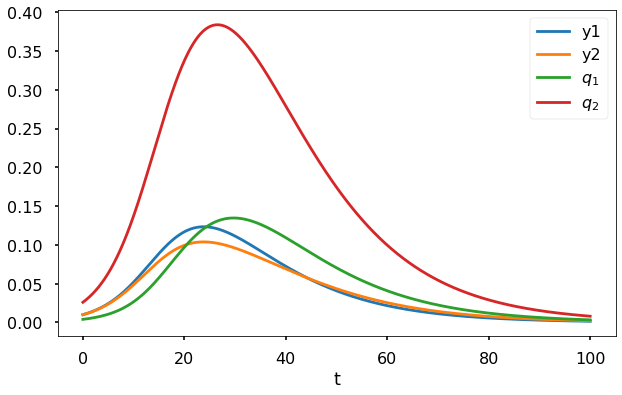

In [33]:
fig, ax = plt.subplots(1,1)
ax.plot(t,y1)
ax.plot(t,y2)
ax.plot(t,q1star)
ax.plot(t,q2star)
ax.legend(['y1','y2','$q_1$','$q_2$']);
plt.xlabel('t');

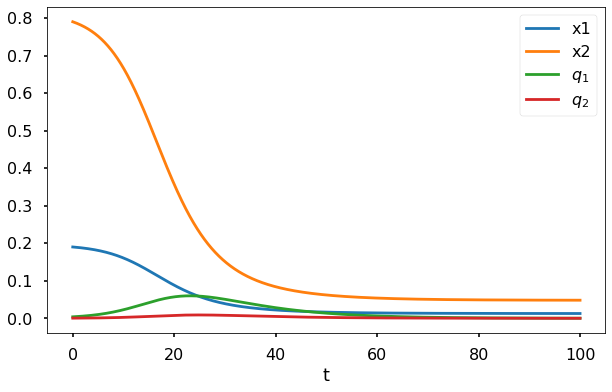

In [32]:
fig, ax = plt.subplots(1,1)
ax.plot(t,x1)
ax.plot(t,x2)
ax.plot(t,q1star)
ax.plot(t,q2star)
ax.legend(['x1','x2','$q_1$','$q_2$']);
plt.xlabel('t');

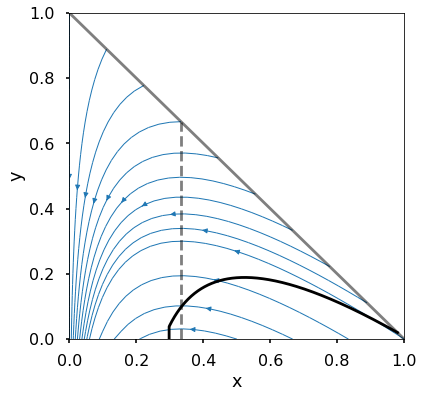

In [574]:
N1 = 10; N2=5
Y, X = np.mgrid[0:1:100j, 0:1:100j]
U = -beta*X*Y
V = beta*X*Y - gamma*Y
x_points = list(np.linspace(0,1,N1)) + list(np.linspace(1./sigma0,1,N2))
y_points = list(1.-np.linspace(0,1,N1)) + [1.e-6]*N2
seed_points = np.array([x_points, y_points])

plt.figure(figsize=(6,6))
plt.streamplot(X, Y, U, V, start_points=seed_points.T,integration_direction='forward',maxlength=1000,
               broken_streamlines=False,linewidth=1)
plt.plot([0,1],[1,0],'-k',alpha=0.5)
plt.plot(x,y,'-k')
plt.plot([gamma/beta, gamma/beta],[0,1-gamma/beta],'--k',alpha=0.5)
plt.xlim(0,1); plt.ylim(0,1);
plt.xlabel('x'); plt.ylabel('y')
plt.savefig('example1_xy.pdf')

In [552]:
x2[-1]/x1[-1]

0.642075102087294

In [17]:
beta = 0.3
gamma = 0.1
sigma0 = beta/gamma
qmax = 1.0
c1 = 1.
c2 = 1.
c3 = 1.e-5

def rhs(t, u):
    # Variables: x1, x2, y1, y2, lambda_1, lambda_2, lambda_3, lambda_4
    du = np.zeros((8,len(t)))
    x1 = u[0,:]; x2 = u[1,:]; x=x1+x2
    y1 = u[2,:]; y2 = u[3,:]; y=y1+y2
    lam1 = u[4,:]; lam2 = u[5,:]; lam3 = u[6,:]; lam4 = u[7,:]

    q1star = (lam3-lam1)*beta*x1*y/(2*c3)
    q1star = np.maximum(0,np.minimum(1,q1star))

    q2star = (lam4-lam2)*beta*x2*y/(2*c3)
    q2star = np.maximum(0,np.minimum(1,q2star))

    du[0,:] = -(1-q1star)*beta*y*x1
    du[1,:] = -(1-q2star)*beta*y*x2
    du[2,:] = (1-q1star)*beta*y*x1 - gamma*y1
    du[3,:] = (1-q2star)*beta*y*x2 - gamma*y2

    du[4,:] = (lam1-lam3)*(1-q1star)*beta*y # - c3*dL/dx1
    du[5,:] = (lam2-lam4)*(1-q2star)*beta*y # - c3*dL/dx2
    du[6,:] = (lam1-lam3)*(1-q1star)*beta*x1 + (lam2-lam4)*(1-q2star)*beta*x2 + lam3*gamma # -c3*dL/dy1
    du[7,:] = (lam1-lam3)*(1-q1star)*beta*x1 + (lam2-lam4)*(1-q2star)*beta*x2 + lam4*gamma # -c3*dL/dy2

    return du

def jac(t, u):
    m = u.shape[1]
    M = np.zeros((8,8,m))

    x1 = u[0,:]; x2 = u[1,:]; x=x1+x2
    y1 = u[2,:]; y2 = u[3,:]; y=y1+y2
    lam1 = u[4,:]; lam2 = u[5,:]; lam3 = u[6,:]; lam4 = u[7,:]

    q1 = (lam3-lam1)*beta*x1*y/(2*c3)
    q1 = np.maximum(0,np.minimum(1,q1))

    q2 = (lam4-lam2)*beta*x2*y/(2*c3)
    q2 = np.maximum(0,np.minimum(1,q2))

    M[0,0,:] = -(1-q1)*y*beta
    M[0,1,:] = 0.
    M[0,2,:] = -(1-q1)*beta*x1
    M[0,3,:] = -(1-q1)*beta*x1

    M[1,0,:] = 0.
    M[1,1,:] = -(1-q2)*y*beta
    M[1,2,:] = -(1-q2)*beta*x2
    M[1,3,:] = -(1-q2)*beta*x2

    M[2,0,:] = (1-q1)*y*beta
    M[2,1,:] = 0.
    M[2,2,:] = (1-q1)*beta*x1 - gamma
    M[2,3,:] = (1-q1)*beta*x1

    M[3,0,:] = 0.
    M[3,1,:] = (1-q2)*y*beta
    M[3,2,:] = (1-q2)*beta*x2
    M[3,3,:] = (1-q2)*beta*x2 - gamma

    M[4,2,:] = (lam1-lam3)*(1-q1)*beta
    M[4,3,:] = (lam1-lam3)*(1-q1)*beta
    M[4,4,:] = (1-q1)*beta*y
    M[4,6,:] = -(1-q1)*beta*y

    M[5,2,:] = (lam2-lam4)*(1-q2)*beta
    M[5,3,:] = (lam2-lam4)*(1-q2)*beta
    M[5,5,:] = (1-q2)*beta*y
    M[5,7,:] = -(1-q2)*beta*y

    M[6,0,:] = (lam1-lam3)*(1-q1)*beta
    M[6,1,:] = (lam2-lam4)*(1-q2)*beta
    M[6,4,:] = (1-q1)*beta*x1
    M[6,5,:] = (1-q2)*beta*x2
    M[6,6,:] = -(1-q1)*beta*x1 + gamma
    M[6,7,:] = -(1-q2)*beta*x2

    M[7,0,:] = (lam1-lam3)*(1-q1)*beta
    M[7,1,:] = (lam2-lam4)*(1-q2)*beta
    M[7,4,:] = (1-q1)*beta*x1
    M[7,5,:] = (1-q2)*beta*x2
    M[7,6,:] = -(1-q1)*beta*x1
    M[7,7,:] = -(1-q2)*beta*x2 + gamma

    return M

In [18]:
u1 = np.random.rand(8,1)
pert = np.random.rand(8,1)*1e-5
t=np.array([0.])
u2 = u1+pert
diff = rhs(t,u2) - rhs(t,u1)
est = jac(t,u1).squeeze()@pert

In [19]:
diff-est

array([[ 0.00000000e+00],
       [-1.52903632e-11],
       [-4.19662474e-18],
       [ 1.52903769e-11],
       [ 0.00000000e+00],
       [ 3.74663560e-12],
       [ 9.55894050e-13],
       [ 9.55858680e-13]])

In [66]:
import scikits.bvp1lg as bvp